In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
application_train_root = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/data/home-credit-default-risk/application_train.csv')
application_test_root = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/data/home-credit-default-risk/application_test.csv')
display(application_train_root.shape)
display(application_test_root.shape)

(307511, 122)

(48744, 121)

<h3>[Problem 1] Cross Validation</h3>


Let's use the baseline model of 2 features AMT_INCOME_TOTAL and AMT_CREDIT done in the previous assignment. Intuiatively speaking (still unsure about the data), one reason for clients to borrow money is because their income is not enogh for their needs. Moreover, due to their incomes problem, their may have diffuculties in repaying the loans. Therefore, let's use these 2 features as the baseline model

In [ ]:
X = np.array(pd.DataFrame(application_train_root, columns=['AMT_INCOME_TOTAL', 'AMT_CREDIT']))
y = np.array(application_train_root['TARGET'])

display(X[:5])
display(y[:5])

array([[ 202500. ,  406597.5],
       [ 270000. , 1293502.5],
       [  67500. ,  135000. ],
       [ 135000. ,  312682.5],
       [ 121500. ,  513000. ]])

array([1, 0, 0, 0, 0])

In [ ]:
n_folds = 10
kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)

In [ ]:
neigh_auc_score_list = []
lr_auc_score_list = []
dt_auc_score_list = []
rf_auc_score_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lr = make_pipeline(StandardScaler(), LogisticRegression()).fit(X_train, y_train)
    y_pred_proba = lr.predict_proba(X_test)
    lr_auc_score_list.append(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))

    neigh = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1000)).fit(X_train, y_train)
    y_pred_proba = neigh.predict_proba(X_test)
    neigh_auc_score_list.append(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))

    dt = make_pipeline(StandardScaler(), DecisionTreeClassifier()).fit(X_train, y_train)
    y_pred_proba = dt.predict_proba(X_test)
    dt_auc_score_list.append(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))

    rf = make_pipeline(StandardScaler(), RandomForestClassifier()).fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)
    rf_auc_score_list.append(metrics.roc_auc_score(y_test, y_pred_proba[:, 1]))

print("AUC scores: ")
score_df = pd.DataFrame({
            'neigh': neigh_auc_score_list,
            'lr': lr_auc_score_list,
            'dt': dt_auc_score_list,
            'rf': rf_auc_score_list 
})

display(score_df)
display(score_df.describe())

AUC scores: 


,neigh,lr,dt,rf
0,0.568323,0.512369,0.550839,0.553523
1,0.575037,0.511454,0.557552,0.563148
2,0.563339,0.522731,0.545076,0.549264
3,0.576268,0.524992,0.553019,0.555327
4,0.561780,0.527981,0.544315,0.543742
5,0.554554,0.510208,0.536161,0.545226
6,0.567627,0.515175,0.563728,0.565487
7,0.558103,0.513032,0.544175,0.548753
8,0.564027,0.524315,0.540835,0.547636
9,0.573638,0.523728,0.540167,0.544824


,neigh,lr,dt,rf
count,10.000000,10.000000,10.000000,10.000000
mean,0.566270,0.518599,0.547587,0.551693
std,0.007264,0.006733,0.008562,0.007610
min,0.554554,0.510208,0.536161,0.543742
25%,0.562170,0.512535,0.541670,0.545828
50%,0.565827,0.518953,0.544695,0.549009
75%,0.572310,0.524168,0.552474,0.554876
max,0.576268,0.527981,0.563728,0.565487


1000-neighbors model has the highest average score (0.56627)

<h3>[Problem 2] Grid search</h3>

In [ ]:
def create_GSCV_pipeline(scaler=StandardScaler(), estimators=None, scoring = 'roc_auc', para_grid=None, n_jobs = 4, cv = 5):
    model_pipeline = Pipeline([('scaler', scaler), ('cls', estimators)])
    return GridSearchCV(
                estimator=model_pipeline, 
                param_grid=para_grid, 
                scoring=scoring,
                n_jobs=n_jobs,
                cv=cv)

KNeighborsClassifier

In [ ]:
parameters = {
    'cls__n_neighbors': list(np.arange(500, 2001, 100))
}

GSCV_neigh = create_GSCV_pipeline(estimators=KNeighborsClassifier(), para_grid=parameters, n_jobs=None)

GSCV_neigh.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
           

In [ ]:
display(GSCV_neigh.best_params_)
display(GSCV_neigh.best_estimator_)
display(GSCV_neigh.best_score_)

{'cls__n_neighbors': 500}

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('cls',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=500, p=2,
                                      weights='uniform'))],
         verbose=False)

0.5670141626937492

RandomForestClassifier

In [ ]:
parameters = {
    'cls__random_state': list(np.arange(0, 11, 2))
}

GSCV_rf = create_GSCV_pipeline(estimators=RandomForestClassifier(), para_grid=parameters)

GSCV_rf.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                              

In [ ]:
display(GSCV_rf.best_params_)
display(GSCV_rf.best_estimator_)
display(GSCV_rf.best_score_)

{'cls__random_state': 2}

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('cls',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=2,
                                        verbose=0, warm_start=False))],
         verbose=False)

0.5506988910872284

<h3>[Problem 3] Survey from Kaggle Notebooks</h3>

https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

This notebook focus on feature engineering. First they do EDA to find the highest correlation with the target variable, then do polynomial features to create new variable to emphasize the important of some high correlated feature, and explore if there is any new feature that affect the target. Secondly, they do domain knowleadge feature selection which is use our knowleadge about the field to select and transform features that we know they will affect the target.

For the creation of my model, I will refer to this new methods of feature engineering, polynomial feature and domain knowleadge feature selection to improve my model.

<h3>[Problem 4] Creating a model with high generalization performance</h3>

<h4>Goal</h4>

AUC_ROC_SCORE >= 0.65

EDA

Check dtypes

In [ ]:
print("train\n{}\n".format(application_train_root.dtypes.value_counts()))
print("test\n{}".format(application_test_root.dtypes.value_counts()))

train
float64    65
int64      41
object     16
dtype: int64

test
float64    65
int64      40
object     16
dtype: int64


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121]),
 <a list of 122 Text major ticklabel objects>)

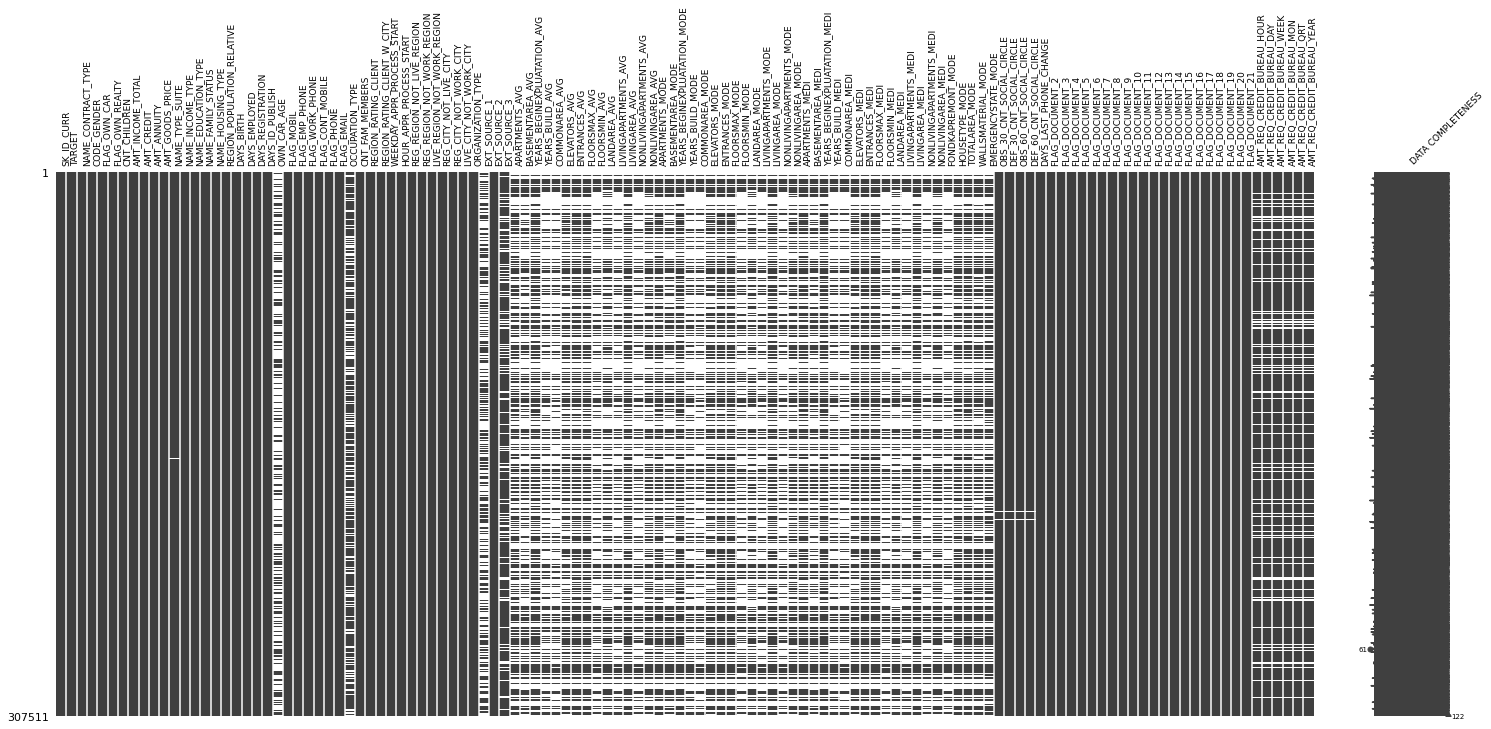

In [ ]:
msno.matrix(application_train_root, labels=True, fontsize=9)
plt.xticks(rotation=90)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120]), <a list of 121 Text major ticklabel objects>)

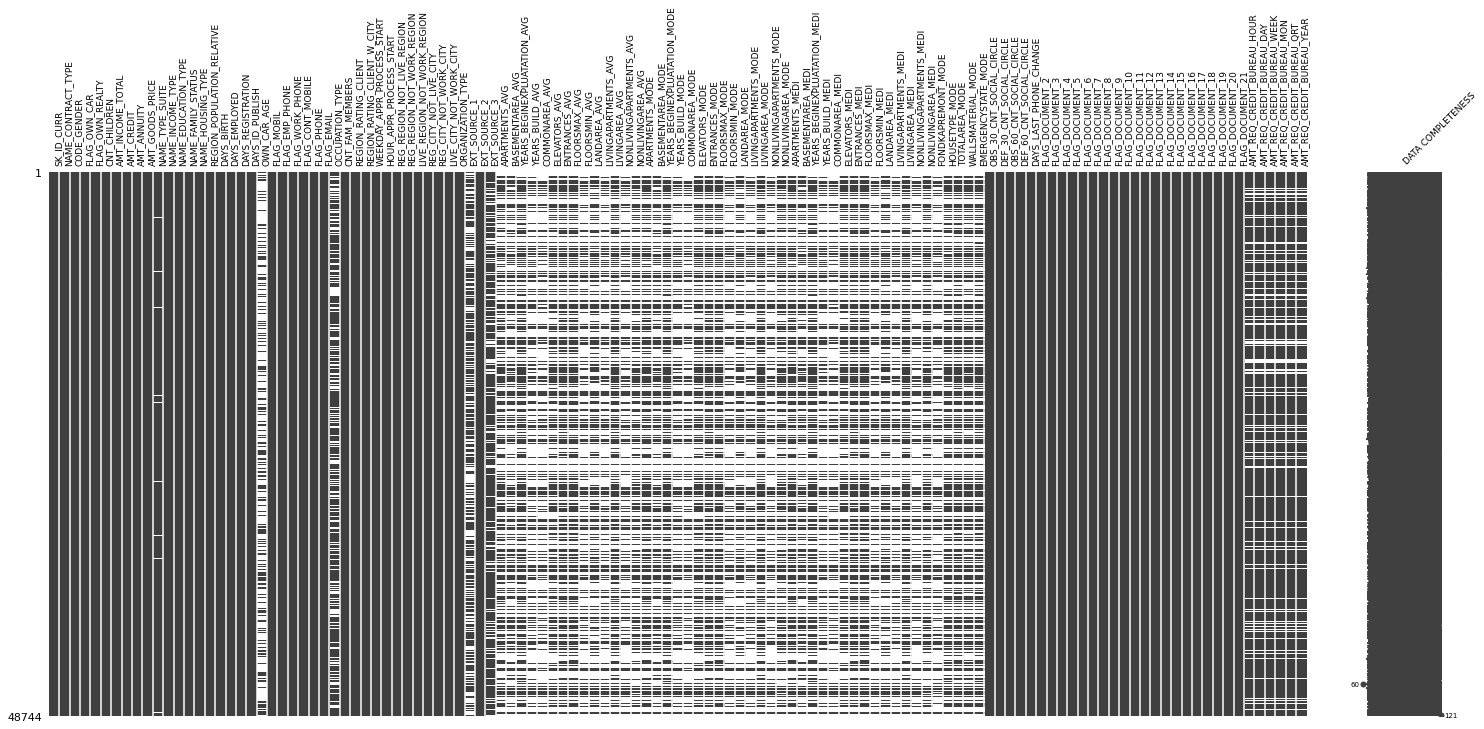

In [ ]:
msno.matrix(application_test_root, labels=True, fontsize=9)
plt.xticks(rotation=90)

<h4>preprocessing</h4>

In [ ]:
application_train1 = pd.get_dummies(application_train_root)
application_test1 = pd.get_dummies(application_test_root)

print("train shape: {}".format(application_train1.shape))
print("test shape: {}".format(application_test1.shape))
print("\ntrain columns:\n{}".format(application_train1.columns))
print("\ntest columns:\n{}".format(application_test1.columns))

train shape: (307511, 246)
test shape: (48744, 242)

train columns:
Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=246)

test columns:
Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
  

In [ ]:
application_train1, application_test1 = application_train1.align(application_test1, join = 'inner', axis = 1)
application_train1['TARGET'] = application_train_root['TARGET']

print("train shape: {}".format(application_train1.shape))
print("test shape: {}".format(application_test1.shape))

train shape: (307511, 243)
test shape: (48744, 242)


In [ ]:
application_train1.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business 

In [ ]:
application_test1.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business 

process missing value

In [ ]:
imputed_train = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(application_train1)
imputed_test = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(application_test1)

application_train1 = pd.DataFrame(imputed_train, columns=application_train1.columns)
application_test1 = pd.DataFrame(imputed_test, columns=application_test1.columns)

print("train missing cols: {}".format(sum(application_train1.isnull().sum() > 0)))
print("test missing cols: {}".format(sum(application_test1.isnull().sum() > 0)))

train missing cols: 0
test missing cols: 0


Find highest relationship score of features with TARGET

In [ ]:
train_corr = application_train1.corr()

10 features have highest absolute corr with TARGET 

In [ ]:
display(abs(train_corr['TARGET']).sort_values(ascending=False)[:10])
display(train_corr['TARGET'].shape)

TARGET                                  1.000000
EXT_SOURCE_2                            0.160295
EXT_SOURCE_3                            0.155892
EXT_SOURCE_1                            0.098887
DAYS_BIRTH                              0.078239
REGION_RATING_CLIENT_W_CITY             0.060893
REGION_RATING_CLIENT                    0.058899
NAME_INCOME_TYPE_Working                0.057481
NAME_EDUCATION_TYPE_Higher education    0.056593
DAYS_LAST_PHONE_CHANGE                  0.055218
Name: TARGET, dtype: float64

(243,)

Corr heatmap among 5 highest corr features

Text(0.5, 1.0, 'Correlation Heatmap')

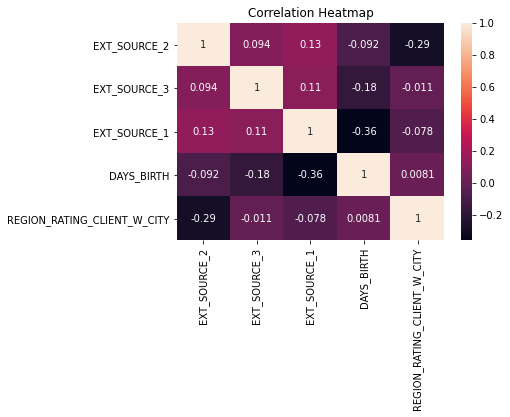

In [ ]:
cols = abs(train_corr['TARGET']).sort_values(ascending=False)[1:6].index

sns.heatmap(train_corr.loc[cols, cols], annot = True)
plt.title('Correlation Heatmap')

10 best features have highest f_score relationship with TARGET

In [ ]:
feature_selector = SelectKBest(k=10).fit(application_train1.iloc[:, 1:-1], application_train1.iloc[:, -1])
display(application_train1.iloc[:, 1:-1].columns[feature_selector.get_support()])

Index(['DAYS_BIRTH', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Higher education'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


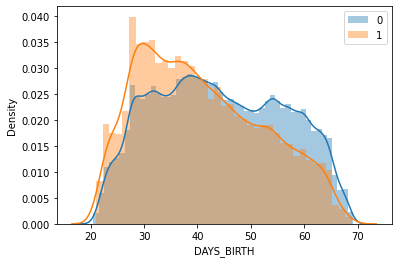

In [ ]:
sns.distplot(abs(application_train1.loc[application_train1['TARGET'] == 0, 'DAYS_BIRTH']) / 365, label='0')
sns.distplot(abs(application_train1.loc[application_train1['TARGET'] == 1, 'DAYS_BIRTH']) / 365, label='1')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


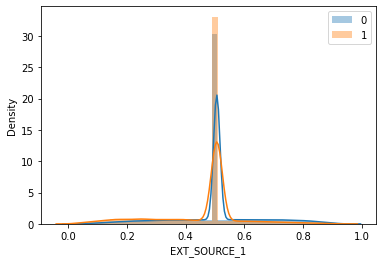

In [ ]:
sns.distplot(application_train1.loc[application_train1['TARGET'] == 0, 'EXT_SOURCE_1'], label='0')
sns.distplot(application_train1.loc[application_train1['TARGET'] == 1, 'EXT_SOURCE_1'], label='1')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


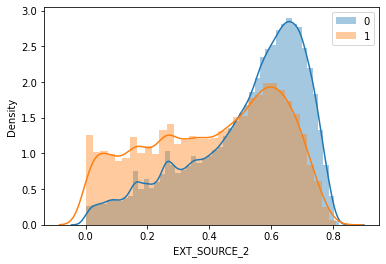

In [ ]:
sns.distplot(application_train1.loc[application_train1['TARGET'] == 0, 'EXT_SOURCE_2'], label='0')
sns.distplot(application_train1.loc[application_train1['TARGET'] == 1, 'EXT_SOURCE_2'], label='1')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


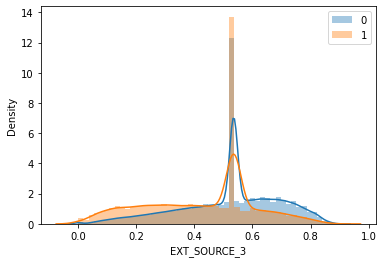

In [ ]:
sns.distplot(application_train1.loc[application_train1['TARGET'] == 0, 'EXT_SOURCE_3'], label='0')
sns.distplot(application_train1.loc[application_train1['TARGET'] == 1, 'EXT_SOURCE_3'], label='1')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


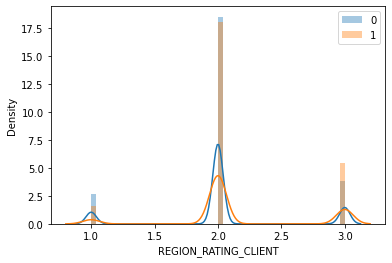

In [ ]:
sns.distplot(application_train1.loc[application_train1['TARGET'] == 0, 'REGION_RATING_CLIENT'], label='0')
sns.distplot(application_train1.loc[application_train1['TARGET'] == 1, 'REGION_RATING_CLIENT'], label='1')
plt.legend()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


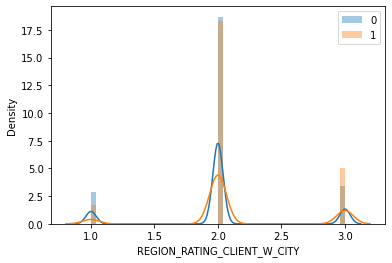

In [ ]:
sns.distplot(application_train1.loc[application_train1['TARGET'] == 0, 'REGION_RATING_CLIENT_W_CITY'], label='0')
sns.distplot(application_train1.loc[application_train1['TARGET'] == 1, 'REGION_RATING_CLIENT_W_CITY'], label='1')
plt.legend()

Feature engineering

Using domain knowleadge feature engineered by Aguiar <br>
https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993

add 4 new features

- CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income
- CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due
- DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [ ]:
application_train2 = pd.DataFrame({
            'TARGET': application_train_root['TARGET'].copy(),
            'CREDIT_INCOME_PERCENT': (application_train1['AMT_CREDIT'] / application_train1['AMT_INCOME_TOTAL']) * 100,
            'ANNUITY_INCOME_PERCENT': (application_train1['AMT_ANNUITY'] / application_train1['AMT_INCOME_TOTAL']) * 100,
            'CREDIT_TERM': (application_train1['AMT_ANNUITY'] / application_train1['AMT_CREDIT']) * 100,
            'DAYS_EMPLOYED_PERCENT': (application_train1['DAYS_EMPLOYED'] / application_train1['DAYS_BIRTH']) * 100
        })

application_train2.head()

application_test2 = pd.DataFrame({
            'CREDIT_INCOME_PERCENT': (application_test1['AMT_CREDIT'] / application_test1['AMT_INCOME_TOTAL']) * 100,
            'ANNUITY_INCOME_PERCENT': (application_test1['AMT_ANNUITY'] / application_test1['AMT_INCOME_TOTAL']) * 100,
            'CREDIT_TERM': (application_test1['AMT_ANNUITY'] / application_test1['AMT_CREDIT']) * 100,
            'DAYS_EMPLOYED_PERCENT': (application_test1['DAYS_EMPLOYED'] / application_test1['DAYS_BIRTH']) * 100
        })

In [ ]:
application_train2.describe()

,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.080729,395.757024,18.092892,5.369534,-292.013487
std,0.272419,268.972819,9.457284,2.248211,662.709787
min,0.000000,0.480762,0.022388,1.678969,-4748.966324
25%,0.000000,201.866667,11.478221,3.690039,2.155855
50%,0.000000,326.506667,16.283333,5.000000,8.864463
75%,0.000000,515.988000,22.906667,6.404315,19.100043
max,1.000000,8473.684211,187.596491,15.811429,72.881149


It is interesting that clients usually borrow the amount of money greater than their income for almost 4 times in average.

In [ ]:
domain_corr = application_train2.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

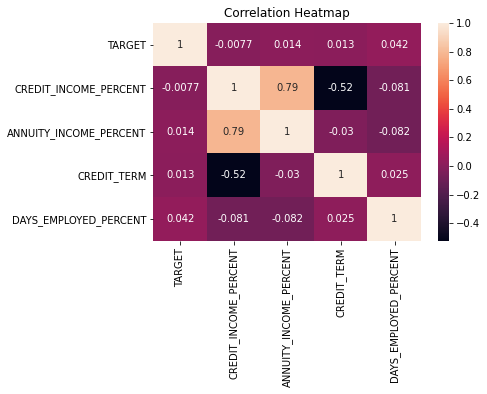

In [ ]:
sns.heatmap(domain_corr, annot = True)
plt.title('Correlation Heatmap')

CREDIT_INCOME_PERCENT and ANNUITY_INCOME_PERCENT have high corr reaching 0.79

In [ ]:
abs(domain_corr['TARGET']).sort_values(ascending=False)

TARGET                    1.000000
DAYS_EMPLOYED_PERCENT     0.042206
ANNUITY_INCOME_PERCENT    0.014268
CREDIT_TERM               0.012698
CREDIT_INCOME_PERCENT     0.007727
Name: TARGET, dtype: float64

<h4>First training attempt using domain knowleadge</h4>

In [ ]:
y = np.array(application_train2['TARGET'].copy())
X = np.array(application_train2.iloc[:, 1:].copy())
X_test = np.array(application_test2.copy())

Random forest

In [ ]:
parameters = {
            'cls__random_state': list(np.arange(0, 11, 2))
}

rf_model0 = create_GSCV_pipeline(estimators=RandomForestClassifier(), para_grid=parameters)

rf_model0.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                              

In [ ]:
display(rf_model0.best_params_)
display(rf_model0.best_estimator_)
display(rf_model0.best_score_)

{'cls__random_state': 10}

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('cls',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=10,
                                        verbose=0, warm_start=False))],
         verbose=False)

0.6070295034939728

In [ ]:
def export_sub_file(id=application_test_root['SK_ID_CURR'].copy(), y_sub=None, file_name=None):
    submission_df = pd.DataFrame({
           'SK_ID_CURR': id,
           'TARGET': y_sub
    })

    submission_df.to_csv('./' + file_name, index=False)

In [ ]:
y_sub = rf_model0.predict_proba(X_test)[:, 1]
export_sub_file(application_test_root['SK_ID_CURR'].copy(), y_sub, 'submission0.csv')

Kaggle

- private score: 0.61463 <br>
- public score: 0.61370

Try with MinMaxScaler()

In [ ]:
parameters = {
            'cls__random_state': list(np.arange(0, 11, 2))
}

rf_model1 = create_GSCV_pipeline(scaler=MinMaxScaler(feature_range = (0, 1)), estimators=RandomForestClassifier(), para_grid=parameters)

rf_model1.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('cls',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                 

In [ ]:
display(rf_model1.best_params_)
display(rf_model1.best_estimator_)
display(rf_model1.best_score_)

{'cls__random_state': 10}

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('cls',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=10,
                                        verbose=0, warm_start=False))],
         verbose=False)

0.6061035155563919

In [ ]:
y_sub = rf_model1.predict_proba(X_test)[:, 1]
export_sub_file(application_test_root['SK_ID_CURR'].copy(), y_sub, 'submission1.csv')

Kaggle

- private score: 0.61118 <br>
- public score: 0.62367

KNeighborsClassifier

In [ ]:
parameters = {
    'cls__n_neighbors': list(np.arange(500, 1501, 200)),
}

neigh_model0 = create_GSCV_pipeline(estimators=KNeighborsClassifier(), para_grid=parameters, n_jobs=None)

neigh_model0.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
           

In [ ]:
display(neigh_model0.best_params_)
display(neigh_model0.best_estimator_)
display(neigh_model0.best_score_)

{'cls__n_neighbors': 500}

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('cls',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=500, p=2,
                                      weights='uniform'))],
         verbose=False)

0.6301908005688448

In [ ]:
y_sub = neigh_model0.predict_proba(X_test)[:, 1]
export_sub_file(application_test_root['SK_ID_CURR'].copy(), y_sub, 'submission2.csv')

Kaggle

- private score: 0.64721 <br>
- public score: 0.65732

-> KNeighborsClassifier is the best method in this context so far

<h4>Improve the model</h4>

Try making prediction with adding 4 more features to the last domain knowledge dataset, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE3, DAY_BIRTH features, which are the top 3 highest corr and f_score relationship with TARGET.

In [ ]:
application_train3 = pd.DataFrame({
            'TARGET': application_train_root['TARGET'].copy(),
            'CREDIT_INCOME_PERCENT': (application_train_root['AMT_CREDIT'] / application_train_root['AMT_INCOME_TOTAL']) * 100,
            'ANNUITY_INCOME_PERCENT': (application_train_root['AMT_ANNUITY'] / application_train_root['AMT_INCOME_TOTAL']) * 100,
            'CREDIT_TERM': (application_train_root['AMT_ANNUITY'] / application_train_root['AMT_CREDIT']) * 100,
            'DAYS_EMPLOYED_PERCENT': (application_train_root['DAYS_EMPLOYED'] / application_train_root['DAYS_BIRTH']) * 100,
            'EXT_SOURCE_1': application_train_root['EXT_SOURCE_1'].copy(),
            'EXT_SOURCE_2': application_train_root['EXT_SOURCE_2'].copy(),
            'EXT_SOURCE_3': application_train_root['EXT_SOURCE_3'].copy(),
            'DAYS_BIRTH': application_train_root['DAYS_BIRTH'].copy()
        })

application_test3 = pd.DataFrame({
            'CREDIT_INCOME_PERCENT': (application_test_root['AMT_CREDIT'] / application_test_root['AMT_INCOME_TOTAL']) * 100,
            'ANNUITY_INCOME_PERCENT': (application_test_root['AMT_ANNUITY'] / application_test_root['AMT_INCOME_TOTAL']) * 100,
            'CREDIT_TERM': (application_test_root['AMT_ANNUITY'] / application_test_root['AMT_CREDIT']) * 100,
            'DAYS_EMPLOYED_PERCENT': (application_test_root['DAYS_EMPLOYED'] / application_test_root['DAYS_BIRTH']) * 100,
            'EXT_SOURCE_1': application_test_root['EXT_SOURCE_1'].copy(),
            'EXT_SOURCE_2': application_test_root['EXT_SOURCE_2'].copy(),
            'EXT_SOURCE_3': application_test_root['EXT_SOURCE_3'].copy(),
            'DAYS_BIRTH': application_test_root['DAYS_BIRTH'].copy()
        })

display(application_train3.head())
display(application_test3.head())

,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
0,1,200.788889,12.197778,6.074927,6.732903,0.083037,0.262949,0.139376,-9461
1,0,479.075000,13.221667,2.759832,7.086191,0.311267,0.622246,NaN,-16765
2,0,200.000000,10.000000,5.000000,1.181350,NaN,0.555912,0.729567,-19046
3,0,231.616667,21.990000,9.494135,15.990529,NaN,0.650442,NaN,-19005
4,0,422.222222,17.996296,4.262281,15.241822,NaN,0.322738,NaN,-19932


,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
0,421.333333,15.230000,3.614715,12.104360,0.752614,0.789654,0.159520,-19241
1,225.018182,17.545455,7.797350,24.739814,0.564990,0.291656,0.432962,-18064
2,327.537778,34.457778,10.520245,22.247729,NaN,0.699787,0.610991,-20038
3,500.000000,15.561429,3.112286,13.351460,0.525734,0.509677,0.612704,-13976
4,347.500000,17.815000,5.126619,16.802147,0.202145,0.425687,NaN,-13040


Text(0.5, 1.0, 'Correlation Heatmap')

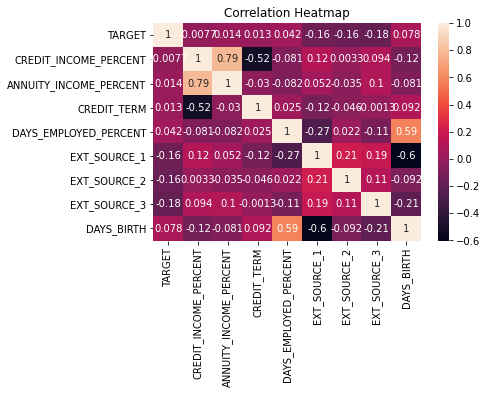

In [ ]:
sns.heatmap(application_train3.corr(), annot = True)
plt.title('Correlation Heatmap')

From the correlation heatmap above, it can be seen that EXT_SOURCE1, EXT_SOURCE2, EXT_SOURCE3, DAYS_BIRTH have generally high correlation with each other from the heatmap above. Therefore, I will try to use these features to help impute each other with KNNImputer.

In [ ]:
imputed_train = KNNImputer(missing_values=np.nan, n_neighbors=500).fit_transform(application_train3.iloc[:, 5:])
imputed_test = KNNImputer(missing_values=np.nan, n_neighbors=500).fit_transform(application_test3.iloc[:, 4:])

imputed_train = pd.DataFrame(imputed_train, columns=application_train3.columns[5:])
imputed_test = pd.DataFrame(imputed_test, columns=application_test3.columns[4:])

application_train3 = pd.concat([application_train3.iloc[:, :5], imputed_train], axis=1)
application_test3 = pd.concat([application_test3.iloc[:, :4], imputed_test], axis=1)

print("train missing cols: {}".format(sum(application_train3.isnull().sum() > 0)))
print("test missing cols: {}".format(sum(application_test3.isnull().sum() > 0)))

train missing cols: 2
test missing cols: 3


In [ ]:
imputed_train = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(application_train3)
imputed_test = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(application_test3)

application_train3 = pd.DataFrame(imputed_train, columns=application_train3.columns)
application_test3 = pd.DataFrame(imputed_test, columns=application_test3.columns)

print("train missing cols: {}".format(sum(application_train3.isnull().sum() > 0)))
print("test missing cols: {}".format(sum(application_test3.isnull().sum() > 0)))

train missing cols: 0
test missing cols: 0


save the newly processed dataset for backing up

In [ ]:
application_train3.to_csv('./application_train3.csv', index=False)
application_test3.to_csv('./application_test3.csv', index=False)

In [ ]:
application_train3 = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/data/home-credit-default-risk/application_train3.csv')
application_test3 = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/data/home-credit-default-risk/application_test3.csv')

Try polynomizing the features and check the correlation with TARGET

In [ ]:
poly_features_train = application_train3.iloc[:, 5:].copy()
poly_features_test = application_test3.iloc[:, 4:].copy()

In [ ]:
poly = PolynomialFeatures(degree=3)
poly.fit(poly_features_train)

poly_features_train = poly.transform(poly_features_train)
poly_features_test = poly.transform(poly_features_test)

display(poly_features_train.shape)
display(poly_features_test.shape)

display(poly.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

(307511, 35)

(48744, 35)

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [ ]:
poly_features_train = pd.DataFrame(poly_features_train, columns=poly.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features_test = pd.DataFrame(poly_features_test, columns=poly.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [ ]:
poly_features_train['TARGET'] = application_train3['TARGET'].copy()

In [ ]:
poly_corr = poly_features_train.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

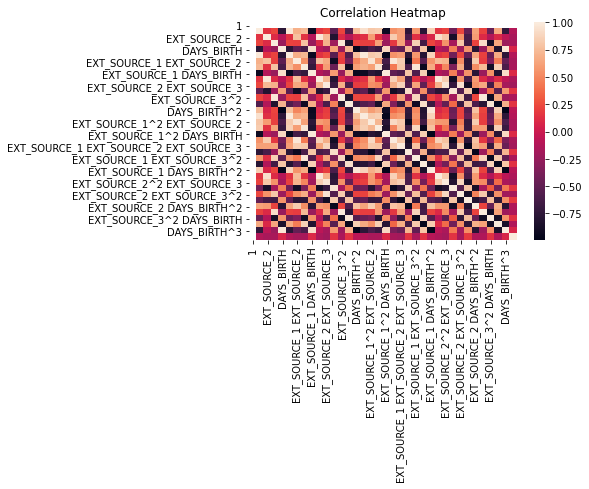

In [ ]:
sns.heatmap(poly_corr)
plt.title('Correlation Heatmap')

10 highest corr features with TARGET

In [ ]:
display(abs(poly_corr['TARGET']).sort_values(ascending=False)[1:11])

EXT_SOURCE_2 EXT_SOURCE_3                 0.194850
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0.188714
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH      0.180248
EXT_SOURCE_2^2 EXT_SOURCE_3               0.176954
EXT_SOURCE_2 EXT_SOURCE_3^2               0.172639
EXT_SOURCE_1 EXT_SOURCE_2                 0.172086
EXT_SOURCE_1 EXT_SOURCE_3                 0.167563
EXT_SOURCE_1 EXT_SOURCE_2^2               0.160417
EXT_SOURCE_2                              0.160320
EXT_SOURCE_3                              0.160318
Name: TARGET, dtype: float64

10 highest f_score features with TARGET

In [ ]:
feature_selector = SelectKBest(k=10).fit(poly_features_train.iloc[:, :-1], poly_features_train['TARGET'])

f_score_df = pd.DataFrame({
            'features': poly_features_train.iloc[:, :-1].columns[feature_selector.get_support()],
            'f_score': feature_selector.scores_[feature_selector.get_support()]
})

display(f_score_df.sort_values(by='f_score', ascending=False))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,features,f_score
4,EXT_SOURCE_2 EXT_SOURCE_3,12135.861700
6,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,11355.740113
9,EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH,10326.299064
7,EXT_SOURCE_2^2 EXT_SOURCE_3,9940.190621
8,EXT_SOURCE_2 EXT_SOURCE_3^2,9446.653315
2,EXT_SOURCE_1 EXT_SOURCE_2,9384.310818
3,EXT_SOURCE_1 EXT_SOURCE_3,8883.497062
5,EXT_SOURCE_1 EXT_SOURCE_2^2,8122.313362
0,EXT_SOURCE_2,8112.222271
1,EXT_SOURCE_3,8112.006055


It is interesting that there exist some more new features that have higher corr with TARGET. Let's take these features into training

adding these 10 new features to the training dataset

In [ ]:
application_train3 = pd.concat([application_train3.iloc[:, :5], poly_features_train.loc[:, poly_features_train.iloc[:, :-1].columns[feature_selector.get_support()]]], axis=1)
application_test3 = pd.concat([application_test3.iloc[:, :4], poly_features_test.loc[:, poly_features_test.columns[feature_selector.get_support()]]], axis=1)

display(application_train3)
display(application_test3)

check null value

In [ ]:
display(application_train3.isnull().sum())
display(application_test3.isnull().sum())

TARGET                                    0
CREDIT_INCOME_PERCENT                     0
ANNUITY_INCOME_PERCENT                    0
CREDIT_TERM                               0
DAYS_EMPLOYED_PERCENT                     0
EXT_SOURCE_2                              0
EXT_SOURCE_3                              0
EXT_SOURCE_1 EXT_SOURCE_2                 0
EXT_SOURCE_1 EXT_SOURCE_3                 0
EXT_SOURCE_2 EXT_SOURCE_3                 0
EXT_SOURCE_1 EXT_SOURCE_2^2               0
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0
EXT_SOURCE_2^2 EXT_SOURCE_3               0
EXT_SOURCE_2 EXT_SOURCE_3^2               0
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH      0
dtype: int64

CREDIT_INCOME_PERCENT                     0
ANNUITY_INCOME_PERCENT                    0
CREDIT_TERM                               0
DAYS_EMPLOYED_PERCENT                     0
EXT_SOURCE_2                              0
EXT_SOURCE_3                              0
EXT_SOURCE_1 EXT_SOURCE_2                 0
EXT_SOURCE_1 EXT_SOURCE_3                 0
EXT_SOURCE_2 EXT_SOURCE_3                 0
EXT_SOURCE_1 EXT_SOURCE_2^2               0
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3    0
EXT_SOURCE_2^2 EXT_SOURCE_3               0
EXT_SOURCE_2 EXT_SOURCE_3^2               0
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH      0
dtype: int64

<h4>Second training attempt</h4>

In [ ]:
X_train = np.array(application_train3.iloc[:, 1:])
y_train = np.array(application_train3['TARGET'])

X_test = np.array(application_test3)

Using KNeighborsClassifier() due to it appears to be the best one so far in this context

In [ ]:
parameters = {
    'cls__n_neighbors': list(np.arange(100, 1001, 200)),
}

neigh_model1 = create_GSCV_pipeline(estimators=KNeighborsClassifier(), para_grid=parameters, n_jobs=None)

neigh_model1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
           

In [ ]:
display(neigh_model1.best_params_)
display(neigh_model1.best_estimator_)
display(neigh_model1.best_score_)

{'cls__n_neighbors': 1000}

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('cls',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=1000, p=2,
                                      weights='uniform'))],
         verbose=False)

0.7264888455299536

In [ ]:
y_sub = neigh_model1.predict_proba(X_test)[:, 1]
export_sub_file(application_test_root['SK_ID_CURR'].copy(), y_sub, 'submission3.csv')

Kaggle

- private score: 0.71275 <br>
- public score: 0.72289

Outstanding move!

<h4>Summary</h4>

<ol>
<li>Set the goal which is the score >= 0.65.</li>
<li>Doing EDA and process missing value using SimpleImputer 'median'.</li>
<li>Find features that have highest correlation with TARGET.</li>
<li>Do feature engineering using domain knowleadge from an expert.</li>
<li>Make first training attempt using domain knowleadge and RandomForestClassifier().</li>
    - **Kaggle score: ~0.61** => Better than the pre-learning assignment.
<li>Try using MixMaxScaler() rather than StandardScaler() for preprocessing and RandomForestClassifier().</li>
    - **Kaggle score: ~0.62** => Better than the first attempt a little bit
<li>Try using KNeighborsClassifier().</li>
    - **Kaggle score: ~0.65** => KNeighborsClassifier() is the best one so far, also reaching my goal.

</ol>

Try to improve the model

<ol>
<li>Adding more features that have highest correlation with the TARGET as previously explored.</li>
<li>Try new processing missing value method using class KNNImputer.</li>
<li>Try polynomizing the features and check the correlation with TARGET.</li>
<li>Choose the highest correlation of newly created features with the TARGET (some of them are much better in correlation).</li>
<li>Make second training attempt using both domain knowledge and polynomized features with KNeighborsClassifier().</li>
     - **Kaggle score: ~0.72** => Unexpected score which is much higher than my goal!
</ol>

<h3>[Problem 5] Final model selection</h3>

The best model so far is the model that combinate both domain knowledge features and highest correlated polynomized features with TARGET, using KNeighborsClassifier().

Kaggle score

- private score: 0.71275 <br>
- public score: 0.72289